### 1.Google Driveをマウントする

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 2.input データ を読み込む

In [0]:
import pandas as pd # データを扱うライブラリ

test_genba = pd.read_csv('./drive/My Drive/input/test_genba.tsv', encoding='utf-8', delimiter='\t')
test_goto = pd.read_csv('./drive/My Drive/input/test_goto.tsv', encoding='utf-8', delimiter='\t')
train_genba = pd.read_csv('./drive/My Drive/input/train_genba.tsv', encoding='utf-8', delimiter='\t')
train_goto = pd.read_csv('./drive/My Drive/input/train_goto.tsv', encoding='utf-8', delimiter='\t')

### 3.input データの表示(確認)

In [0]:
test_genba.head(3)

In [0]:
test_goto.head(3)

In [0]:
train_genba.head(3)

### 4.tarinデータとtestデータ の作成

In [0]:
# 現場データと号棟データをそれぞれpj_noで結合する
train=pd.merge(train_goto,train_genba, on=['pj_no',], how='outer')
test=pd.merge(test_goto,test_genba, on=['pj_no',], how='outer')

### 5.tarinデータとtestデータの表示(確認)

In [0]:
train.shape

(6461, 158)

In [0]:
test.shape

(4273, 157)

### 6.変数加工_1

In [0]:
import numpy as np
import xgboost as xgb

# 予測対象のid
id_test=test["id"]

# 目的変数(計算用に対数変換する)
train_ylog = np.log1p(train["keiyaku_pr"].values)
train_y = train_ylog.tolist()

# 説明変数に不要な列を削除
del train["id"]
del train["keiyaku_pr"]
del test["id"]

# 変数加工用にtrainとtestを一旦結合する
df_all=pd.concat([train, test])

# カテゴリカル変数をダミー化
df_all = pd.get_dummies(df_all, drop_first=True) # drop_first=Trueでk-1個のダミー変数となる


### 7.変数加工_2

In [0]:
# trainとtestを再度分割する
train_x = df_all[:6461]
test = df_all[6461:]

# 学習用、検証用データ作成
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(train_x,
                                                      train_y,
                                                      test_size = 0.3,
                                                      random_state = 666)

# XGBoostの関数に入れる形に整形
dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_test, label = y_test)
dtrain_all = xgb.DMatrix(train_x, train_y)
dtest = xgb.DMatrix(test)

### 8.精度検証用のモデルを作成

In [0]:
# モデルのパラメーターを設定
xgb_params = {
    'eta': 0.01,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'silent': 1
}

# 学習データと検証データで学習
partial_model = xgb.train(xgb_params, 
                          dtrain,
                          num_boost_round=10000,
                          evals=[(dval, 'val')],
                          early_stopping_rounds=100,
                          verbose_eval=100)

num_boost_round = partial_model.best_iteration

### 9.精度検証用モデルの変数重要度を表示

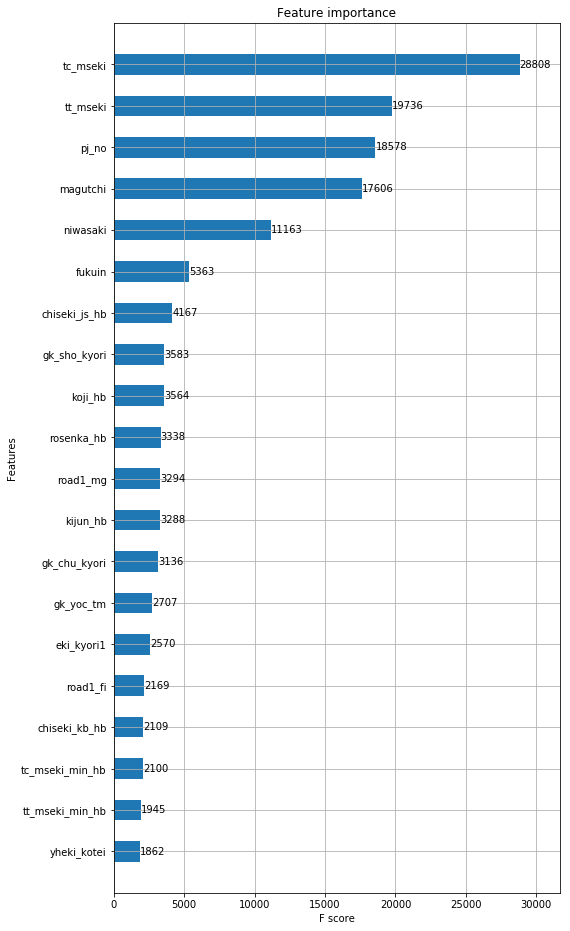

In [0]:
# 変数重要度をプロット(top20)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=20, height=0.5, ax=ax)

### 10.学習データ全量でモデル作成

In [0]:
# trainデータ全量でモデルを学習
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params,silent=1),
                  dtrain_all,
                  num_boost_round=num_boost_round)

In [0]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model=model,
                               feature_dependence='tree_path_dependent',
                               model_output='margin')

shap_values = explainer.shap_values(X=train_x)
shap.summary_plot(shap_values, train_x, plot_type="bar")

### 11.予測対象の予測と結果出力

In [0]:
# testデータを予測
ylog_pred = model.predict(dtest)

# 自然対数から変換する
y_pred = np.exp(ylog_pred) - 1

# 提出フォーマットに整形
id_test=test_goto["id"]
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
df_sub.to_csv('./drive/My Drive/xgboost_02.tsv',sep='\t', index=False, header=False)